In [64]:
import sys
if '/home/ross/immunova' not in sys.path:
    sys.path.append('/home/ross/immunova')
from immunova.data.fcs_experiments import FCSExperiment
from immunova.data.utilities import get_fcs_file_paths
from immunova.flow.gating.utilities import centroid
from immunova.flow.gating.actions import Gating, Template
from immunova.flow.gating.defaults import ChildPopulationCollection
from immunova.data.mongo_setup import pd_test_init
import warnings
warnings.filterwarnings('ignore')
pd_test_init()

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from bokeh.io import curdoc
from bokeh.layouts import row, column
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import PreText, Select
from bokeh.plotting import figure
import pandas as pd
import phenograph
import umap
import random

In [3]:
def random_colours(n):
    colours = list()
    while len(colours) < n:
        r = lambda: random.randint(0,255)
        c = '#%02X%02X%02X' % (r(),r(),r())
        if c not in colours:
            colours.append(c)
    return colours

In [ ]:
t = FCSExperiment.objects(experiment_id='PD_T').get()

In [65]:
def high_dim_plots(exp, sample_id, n):
    print('Loading data...')
    sample = Gating(exp, sample_id)
    sample = sample.labelled_data('live CD3', ['gdt', 'mait', 'CD4', 'CD8'], transform=True)
    #UMAP
    print('Generating UMAP...')
    reducer = umap.UMAP()
    features = ['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'CXCR3', 'CD161',
            'CCR7', 'Va7.2', 'CD8', 'Vd2', 'CD45RA', 'PanGD', 'CD4',
            'CD27']
    if n < sample.shape[0]:
        s = sample.sample(n)
    else:
        s = sample
    
    embeddings = reducer.fit_transform(s[features])
    s['umap0'], s['umap1'] = embeddings[:, 0], embeddings[:, 1]
    
    print('Plotting...')
    # Basic UMAP plot
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(s['umap0'], s['umap1'], s=1, alpha=0.5)
    ax.set_title(f'{sample_id}_UMAP')
    fig.savefig(f'plots/{sample_id}_UMAP.jpg',bbox_inches="tight")
    
    # UMAP 2D Hist
    fig, ax = plt.subplots(figsize=(10,10))
    ax.hist2d(s['umap0'], s['umap1'], bins=(300,300), cmap=plt.cm.jet, norm=LogNorm())
    ax.set_title(f'{sample_id}_UMAP_2DHist (Bins: 300)')
    fig.savefig(f'plots/{sample_id}_UMAP_2DHist.jpg',bbox_inches="tight")

    
    # Plot autogate results (without missing)
    fig, ax = plt.subplots(figsize=(10,10))
    pop_colours = ['red', 'green', 'yellow', 'orange', 'blue']
    for pop, colour in zip(s.label.unique(), pop_colours):
        if pop == 'None':
            continue
        d = s[s.label == pop][['umap0', 'umap1']].values
        ax.scatter(d[:, 0], d[:, 1], c=colour, s=5, alpha=0.35, label=pop)
    ax.legend(loc="lower left", scatterpoints=1, fontsize=10, bbox_to_anchor=(1.02,0))
    ax.set_title(f'{sample_id}_Autogate')
    fig.savefig(f'plots/{sample_id}_Autogate_wo_missing.jpg',bbox_inches="tight")
    
    # Plot autogate results (with missing)
    fig, ax = plt.subplots(figsize=(10,10))
    pop_colours = ['red', 'green', 'yellow', 'orange', 'blue']
    for pop, colour in zip(s.label.unique(), pop_colours):
        if pop == 'None':
            colour='black'
        d = s[s.label == pop][['umap0', 'umap1']].values
        ax.scatter(d[:, 0], d[:, 1], c=colour, s=5, alpha=0.35, label=pop)
    ax.legend(loc="lower left", scatterpoints=1, fontsize=10, bbox_to_anchor=(1.02,0))
    ax.set_title(f'{sample_id}_Autogate')
    fig.savefig(f'plots/{sample_id}_Autogate_w_missing.jpg',bbox_inches="tight")
    
    # Plot autogate results (with missing as kde)
    fig, ax = plt.subplots(figsize=(10,10))
    pop_colours = ['red', 'green', 'yellow', 'orange', 'blue']
    for pop, colour in zip(s.label.unique(), pop_colours):
        if pop == 'None':
            continue
        d = s[s.label == pop][['umap0', 'umap1']].values
        ax.scatter(d[:, 0], d[:, 1], c=colour, s=5, alpha=0.35, label=pop)
    
    x = s[s.label == 'None']['umap0'].values
    y = s[s.label == 'None']['umap1'].values
    sns.kdeplot(x, y, n_levels=30, cmap="Purples_d", ax=ax)
    ax.legend(loc="lower left", scatterpoints=1, fontsize=10, bbox_to_anchor=(1.02,0))
    ax.set_title(f'{sample_id}_Autogate')
    fig.savefig(f'plots/{sample_id}_Autogate_missingkde.jpg',bbox_inches="tight")
    
    print('Generating Phenograph...')
    # Phenograph
    communities, graph, Q = phenograph.cluster(s[features])
    s['clusters'] = communities
    colours = random_colours(len(s.clusters.unique()))
    
    print('Plotting...')
    fig, ax = plt.subplots(figsize=(10,10))
    # Plot UMAP and Phenograph clusters
    colour_dict = {k: v for k, v in zip(s['clusters'].unique(), colours)}
    ax.scatter(s['umap0'],s['umap1'],
               s=1, alpha=0.5, c=s['clusters'].apply(lambda x: colour_dict[x]))
    for label, colour in colour_dict.items():
        d = s[s['clusters'] == label]
        center = centroid(d[['umap0', 'umap1']].values)
        ax.scatter(center[0], center[1], s=40, c=[colour], label=f'Cluster {label}', 
                   linewidth=1, edgecolors='black')
    ax.legend(loc="lower left", scatterpoints=1, fontsize=10, bbox_to_anchor=(1.02,0))
    ax.set_title(f'{sample_id}_Phenograph')
    fig.savefig(f'plots/{sample_id}_Phenograph.jpg',bbox_inches="tight")
    
    # Heatmap
    mfi_summary = s.groupby(by='clusters').mean()
    g = sns.clustermap(mfi_summary[[x for x in features if all([y not in x for y in ['FSC', 'SSC']])]],
                       z_score=1, col_cluster=False)
    g.savefig(f'plots/{sample_id}_Phenograph_HM.jpg',bbox_inches="tight")
    print('Complete!')

In [66]:
t.list_samples()

['PD31201',
 '30501PDMC',
 '23904_stable_pbmc',
 '26402_stable_pbmc',
 '29403_stable_pbmc',
 '26702_peri_pbmc',
 '31501_peri_pbmc',
 '30802R_peri_pbmc']

Loading data...
Generating UMAP...
Plotting...
Generating Phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 22.223064184188843 seconds
Jaccard graph constructed in 7.6736061573028564 seconds
Wrote graph to binary file in 5.2384161949157715 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.847666
After 3 runs, maximum modularity is Q = 0.848843
After 12 runs, maximum modularity is Q = 0.851528
Louvain completed 32 runs in 187.73735761642456 seconds
PhenoGraph complete in 223.04722356796265 seconds
Plotting...
Complete!


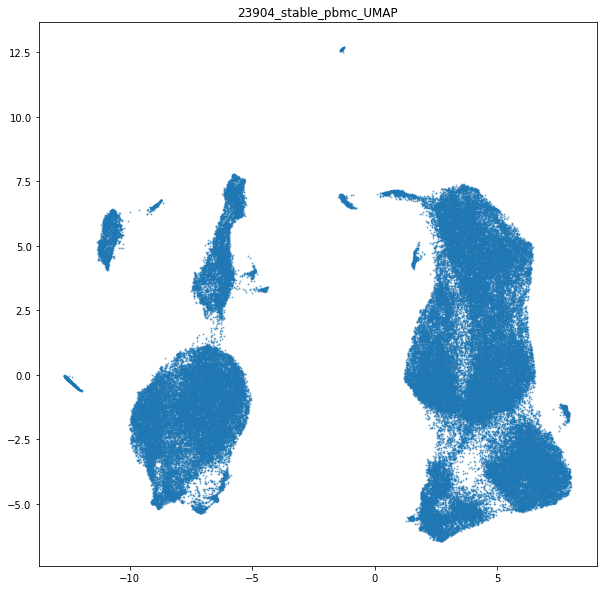

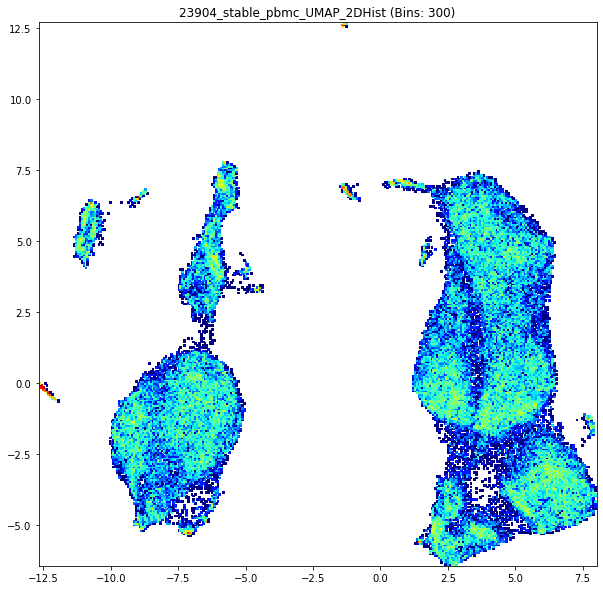

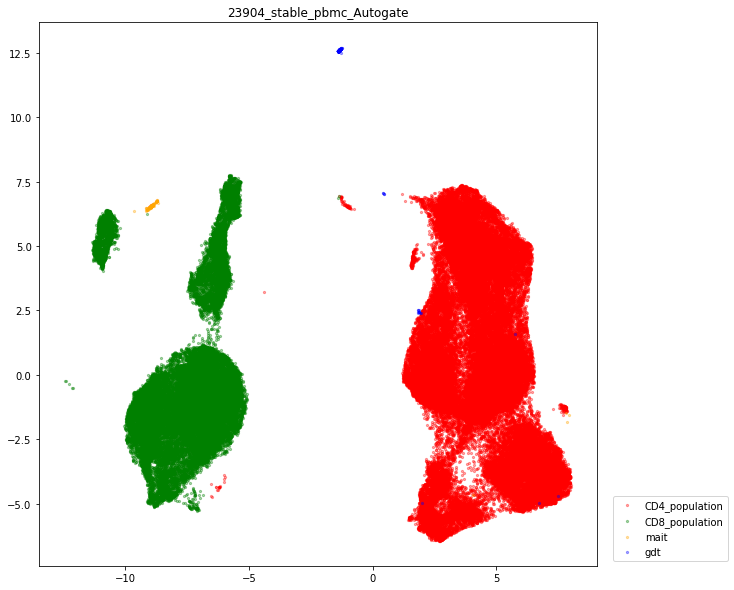

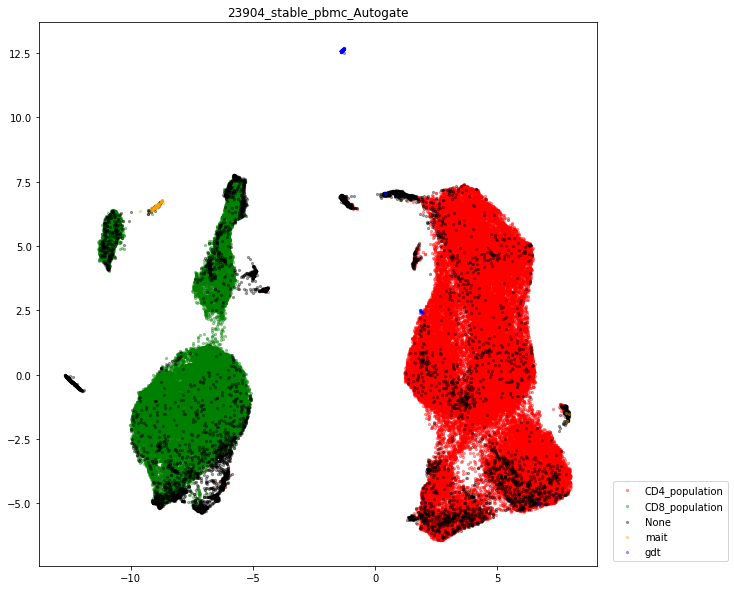

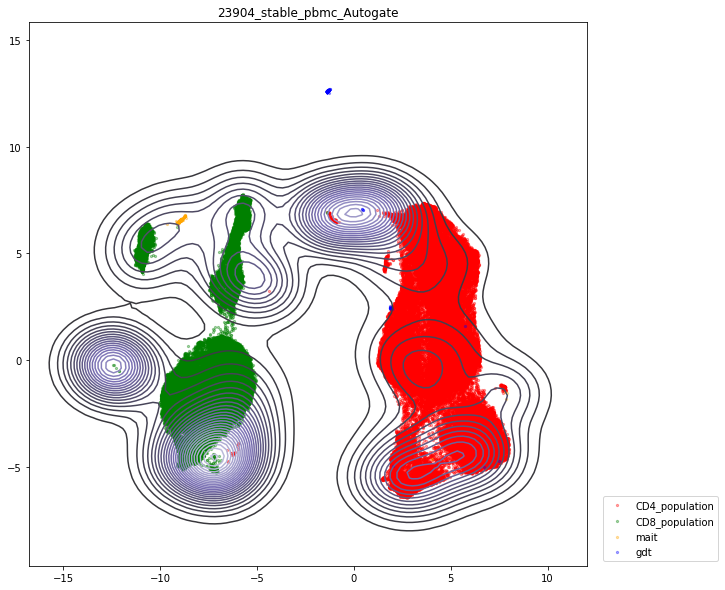

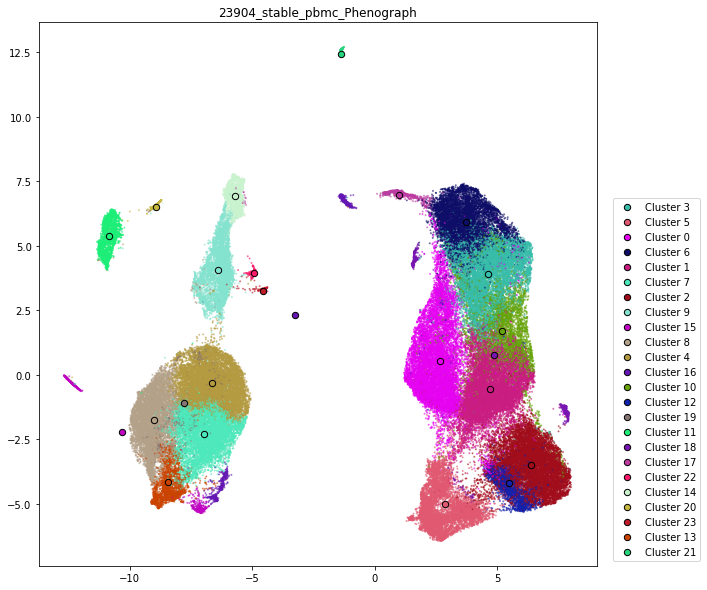

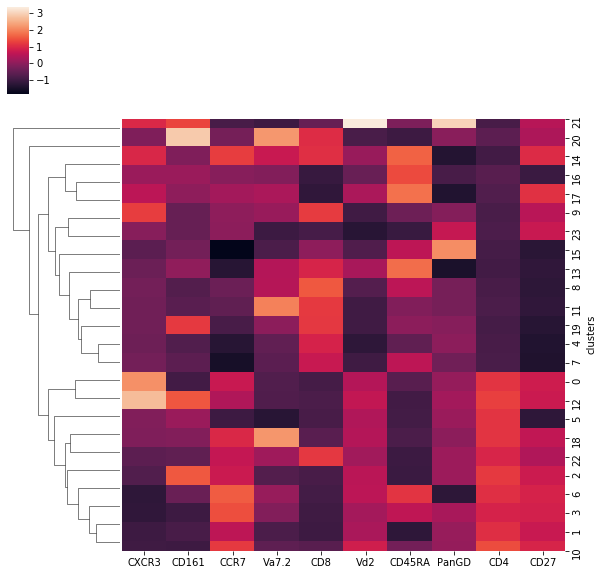

In [67]:
high_dim_plots(t, '23904_stable_pbmc', n=100000)

Loading data...
Generating UMAP...
Plotting...
Generating Phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 24.221769094467163 seconds
Jaccard graph constructed in 6.969865798950195 seconds
Wrote graph to binary file in 5.191760540008545 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.855145
After 12 runs, maximum modularity is Q = 0.857136
Louvain completed 32 runs in 154.98420882225037 seconds
PhenoGraph complete in 191.5319323539734 seconds
Plotting...
Complete!


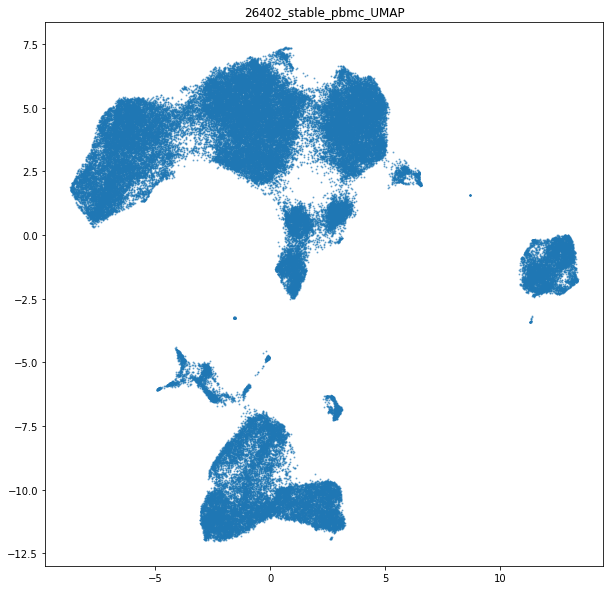

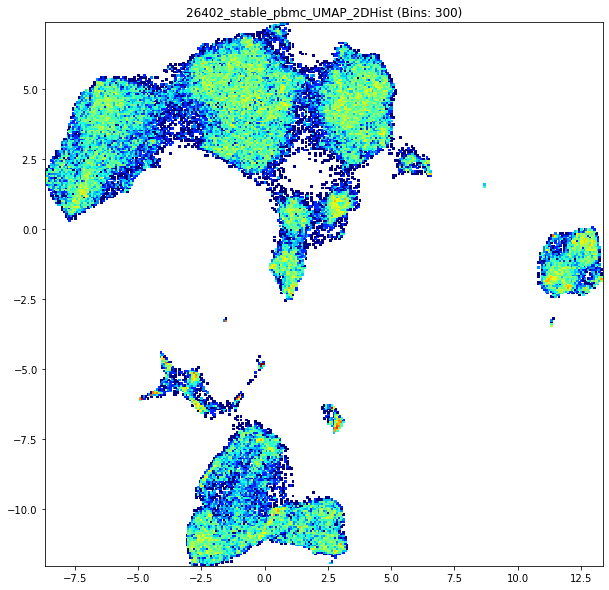

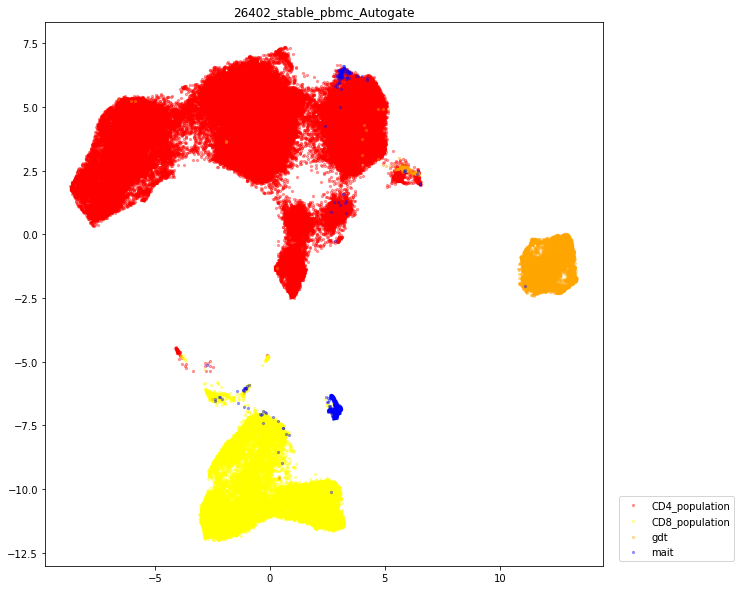

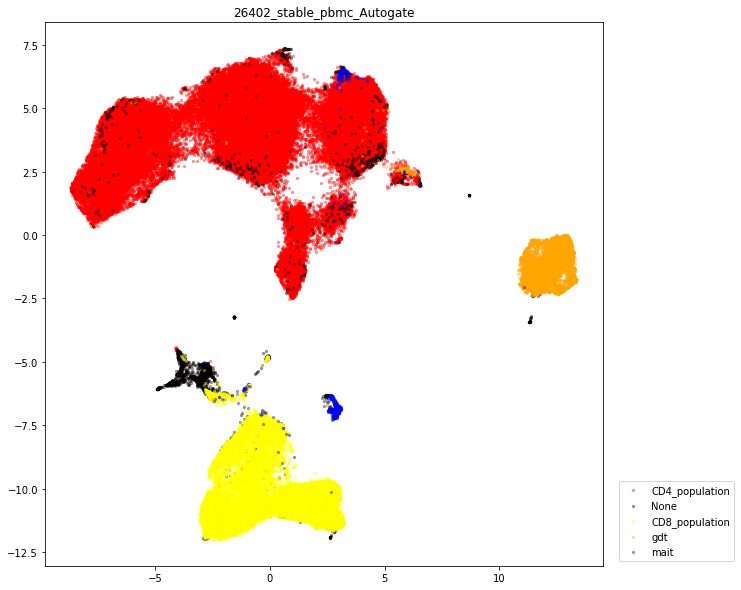

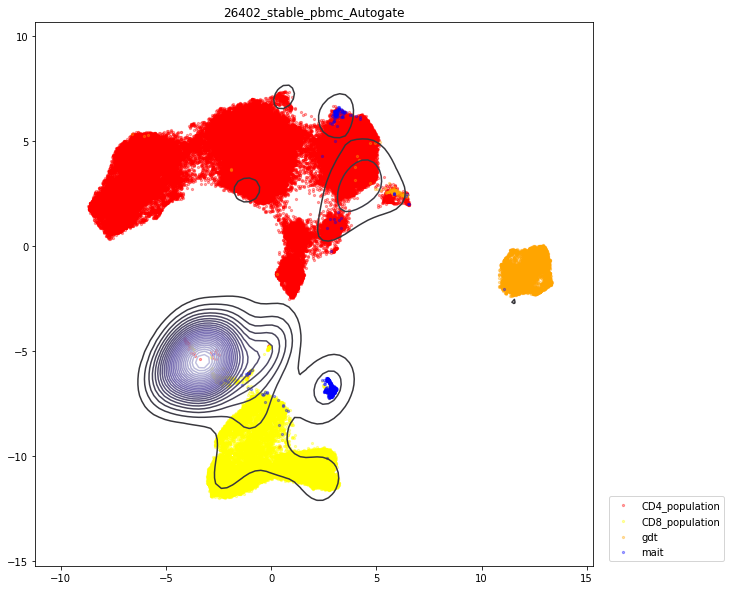

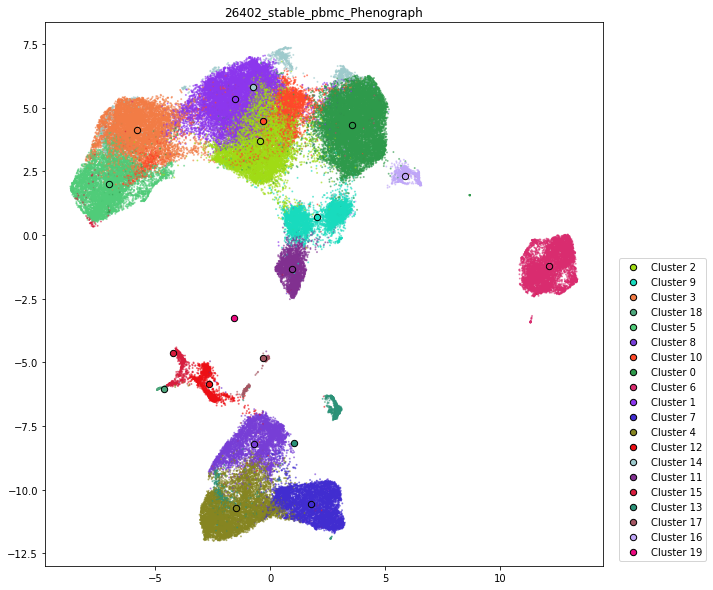

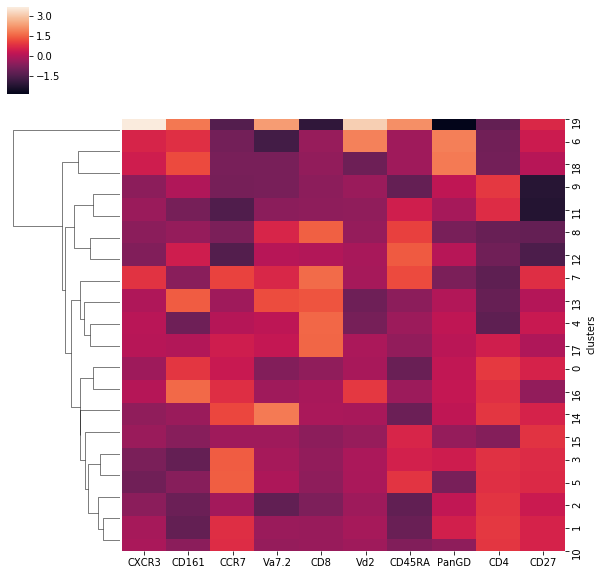

In [68]:
high_dim_plots(t, '26402_stable_pbmc', n=200000)

Loading data...
Generating UMAP...
Plotting...
Generating Phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.479356288909912 seconds
Jaccard graph constructed in 5.739725828170776 seconds
Wrote graph to binary file in 4.466486215591431 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.830487
After 3 runs, maximum modularity is Q = 0.831666
After 5 runs, maximum modularity is Q = 0.833166
Louvain completed 25 runs in 91.76075482368469 seconds
PhenoGraph complete in 111.58967900276184 seconds
Plotting...
Complete!


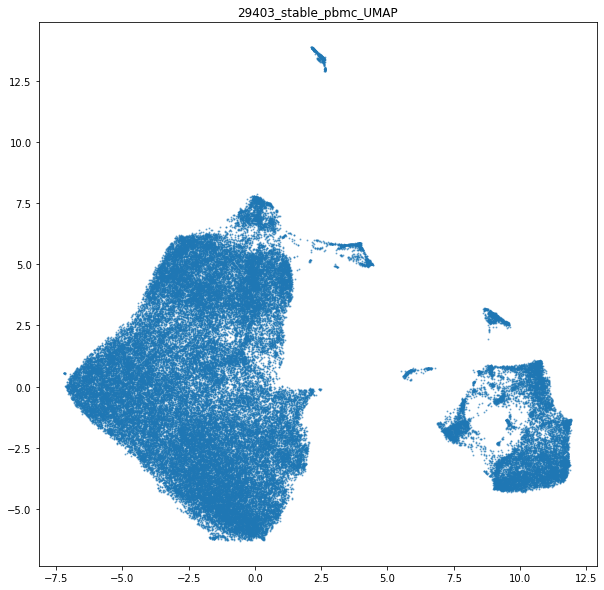

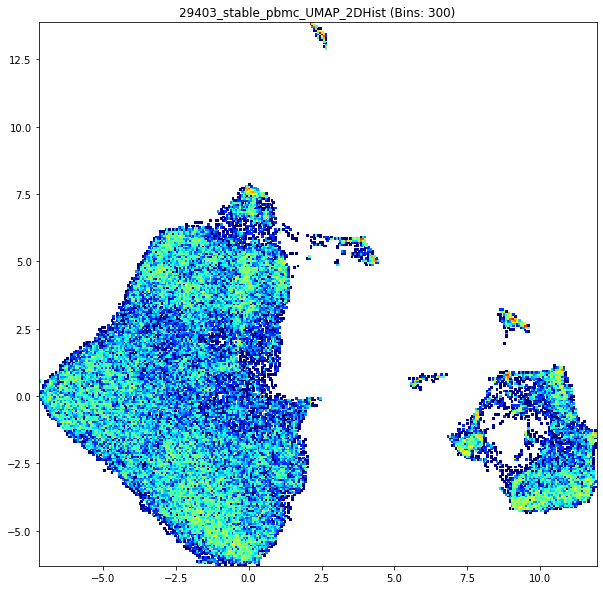

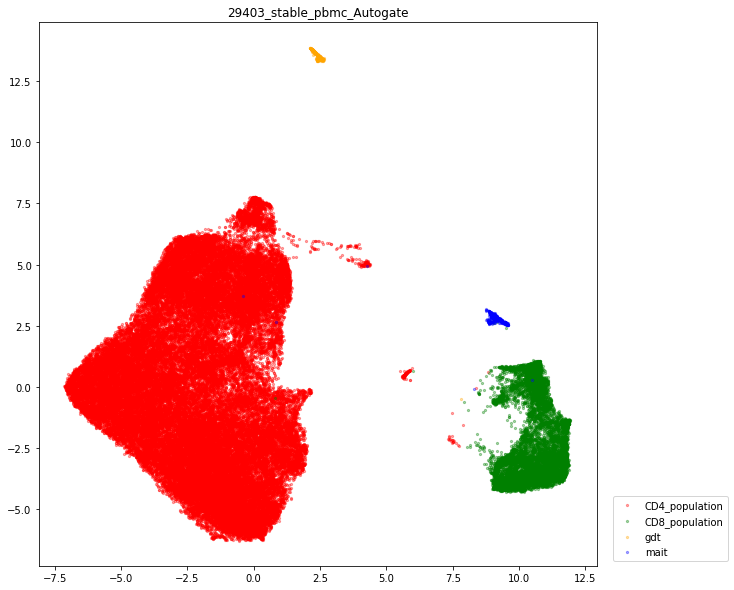

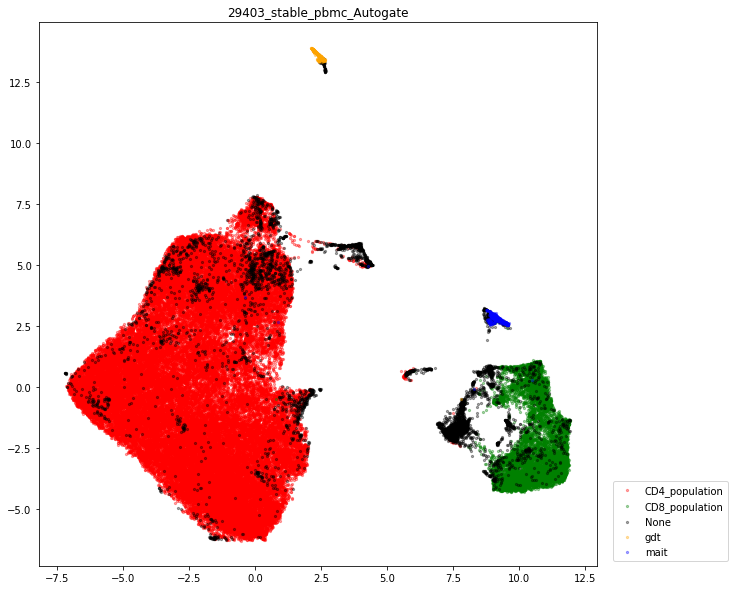

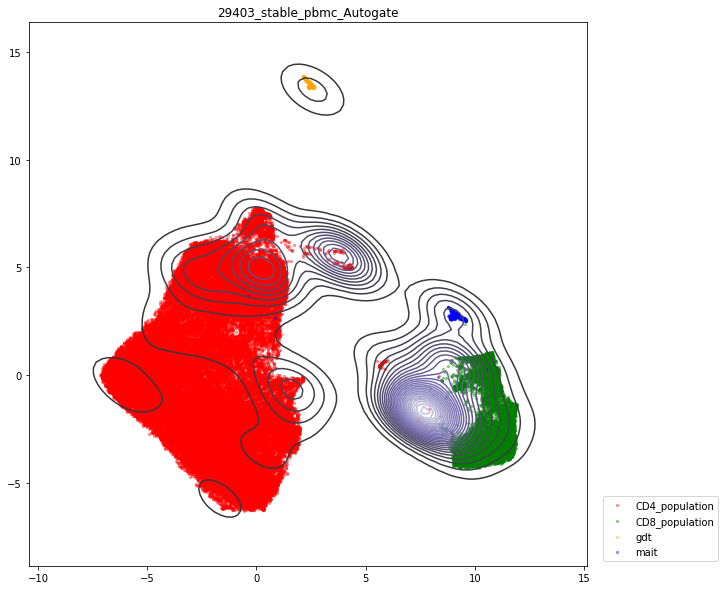

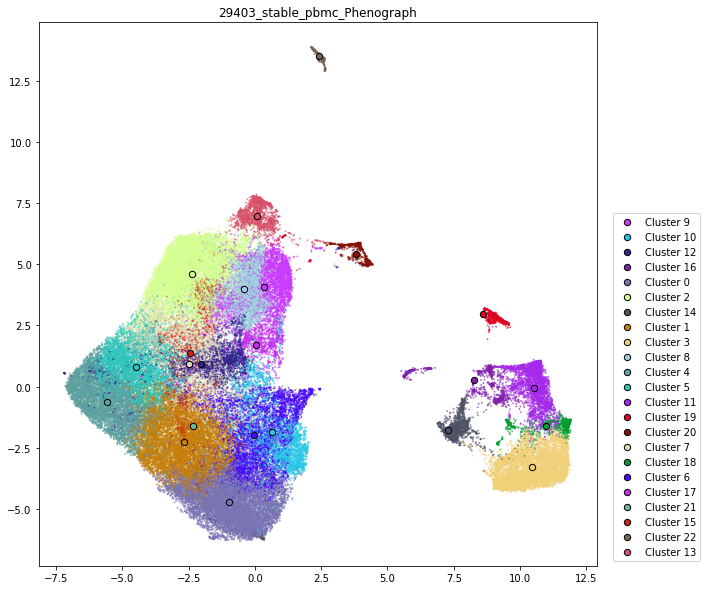

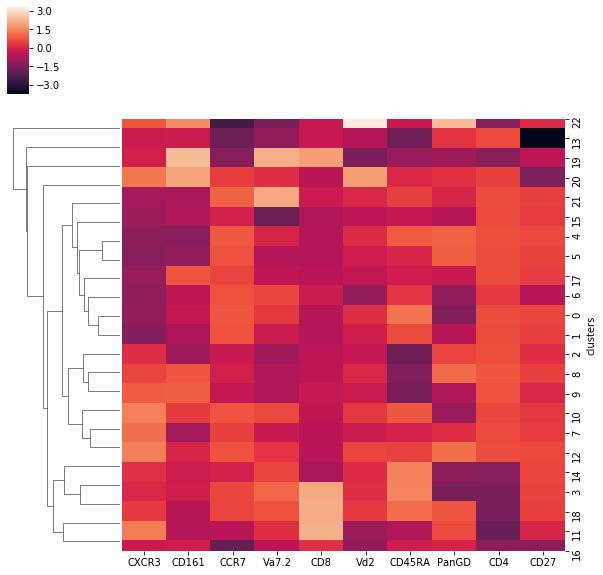

In [69]:
high_dim_plots(t, '29403_stable_pbmc', n=200000)

In [70]:
high_dim_plots(t, '26702_peri_pbmc', n=200000)

Loading data...
Population live CD3 not recognised


TypeError: 'NoneType' object does not support item assignment

In [71]:
x = Gating(t, '26702_peri_pbmc')

Loading data...
Generating UMAP...
Plotting...
Generating Phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 79.14656114578247 seconds
Jaccard graph constructed in 14.881247758865356 seconds
Wrote graph to binary file in 10.52941346168518 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.865759
After 9 runs, maximum modularity is Q = 0.867238
After 25 runs, maximum modularity is Q = 0.8692
Louvain completed 45 runs in 612.2067382335663 seconds
PhenoGraph complete in 717.1288316249847 seconds
Plotting...
Complete!


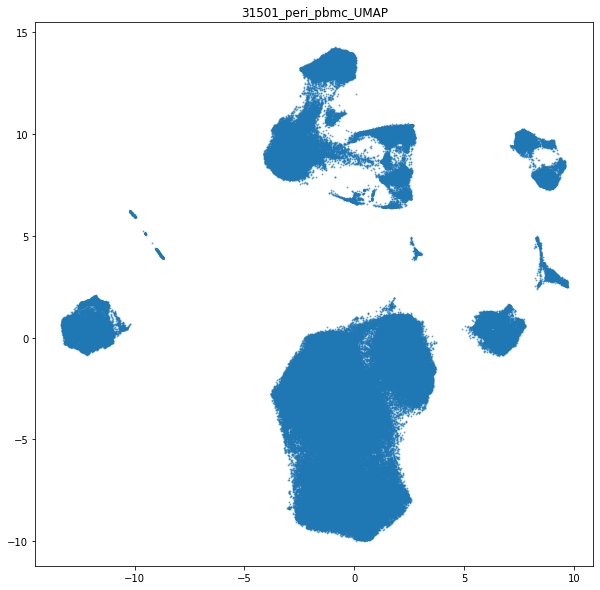

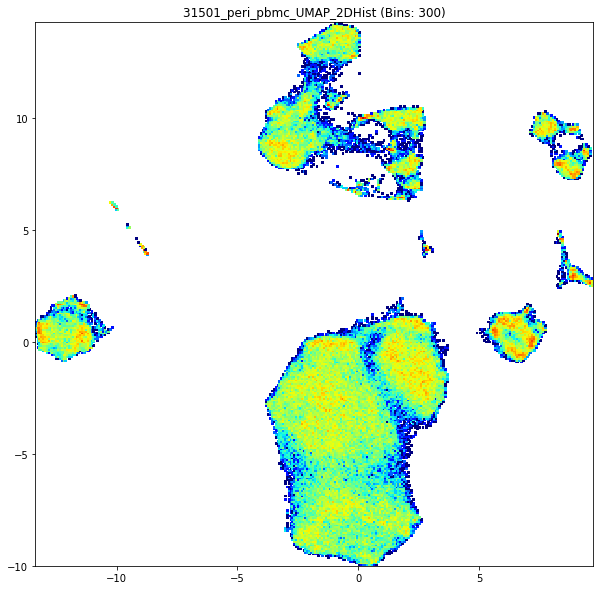

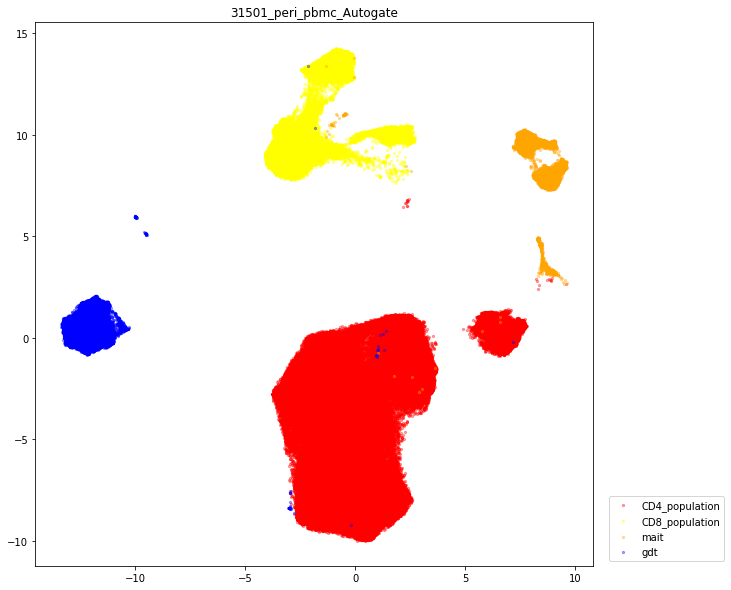

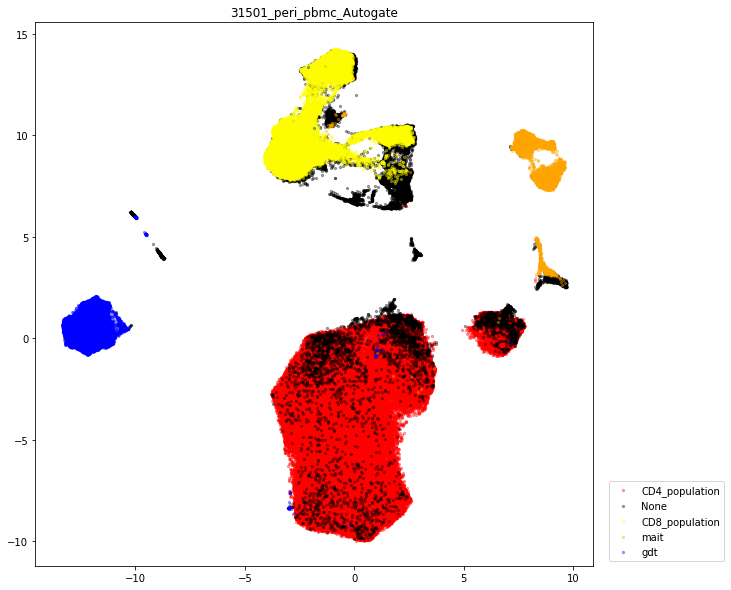

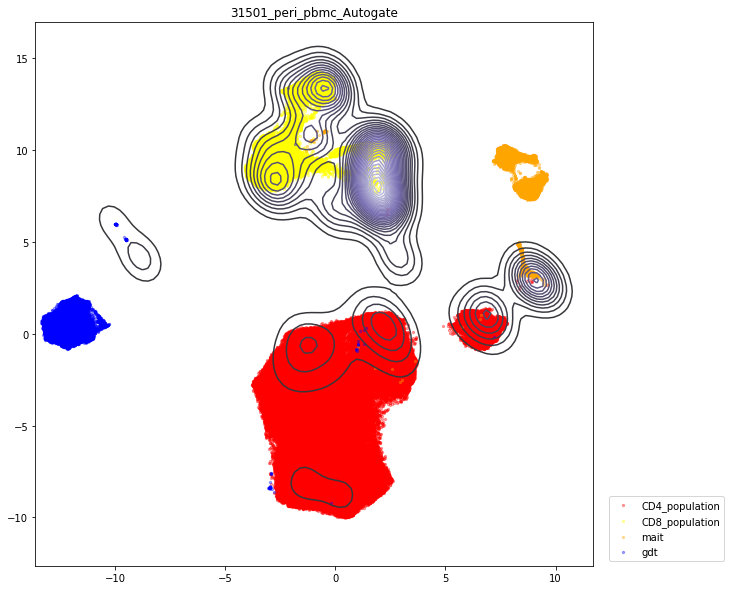

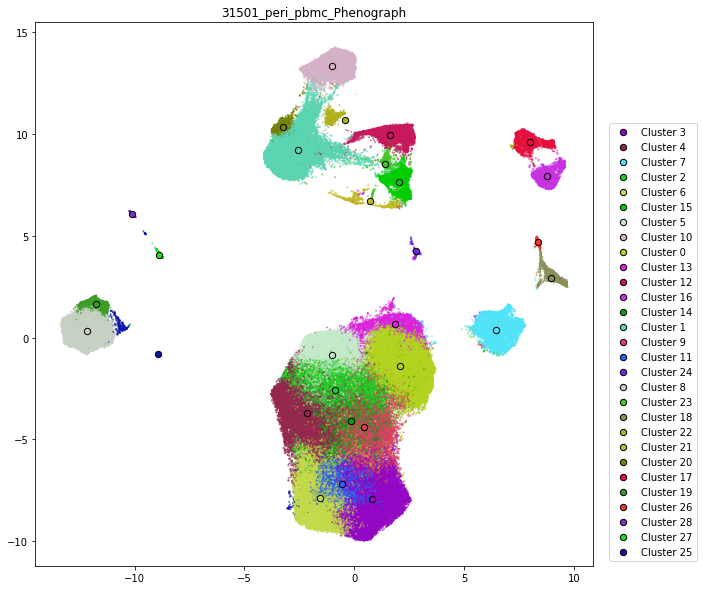

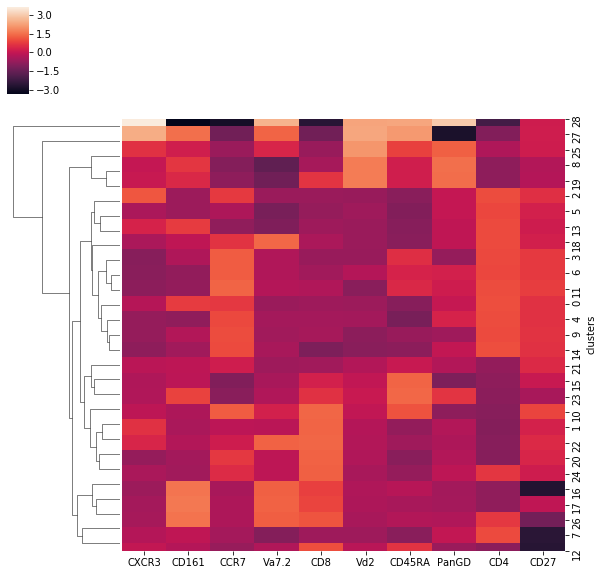

In [73]:
high_dim_plots(t, '31501_peri_pbmc', n=200000)

Loading data...
Generating UMAP...
Plotting...
Generating Phenograph...
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 5.665862798690796 seconds
Jaccard graph constructed in 3.5502891540527344 seconds
Wrote graph to binary file in 2.6199758052825928 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.852274
Louvain completed 21 runs in 36.129852294921875 seconds
PhenoGraph complete in 48.04245734214783 seconds
Plotting...
Complete!


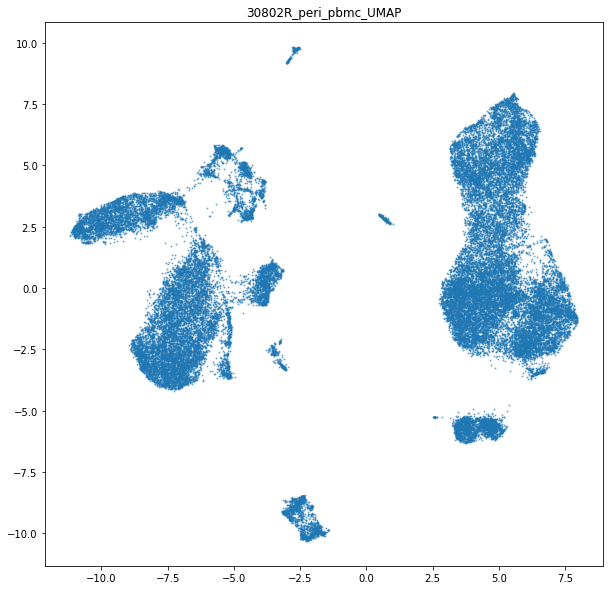

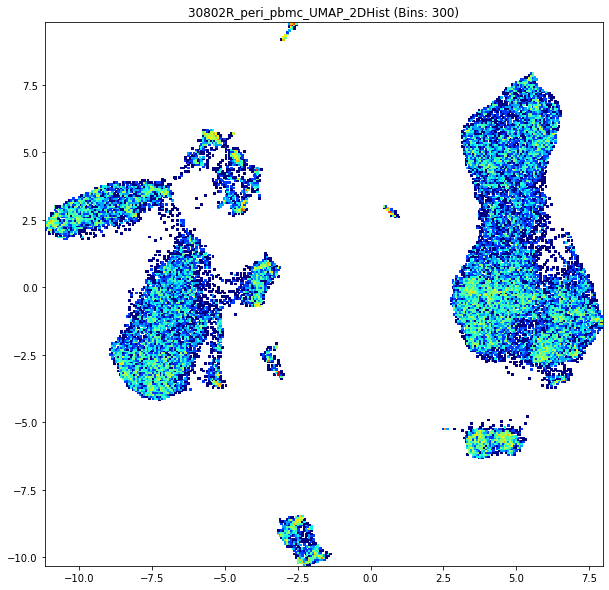

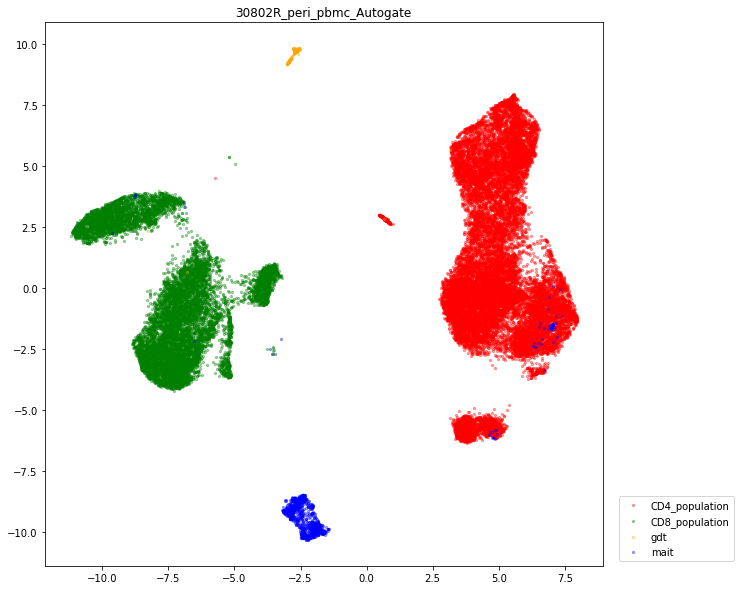

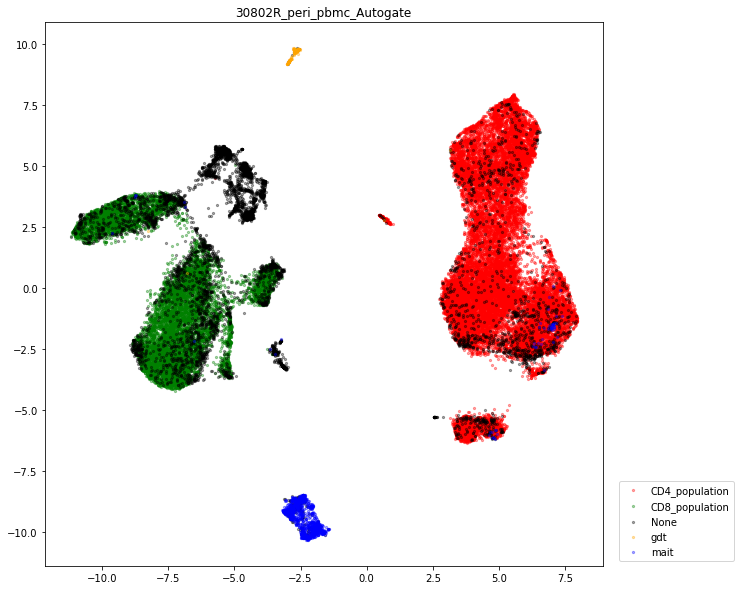

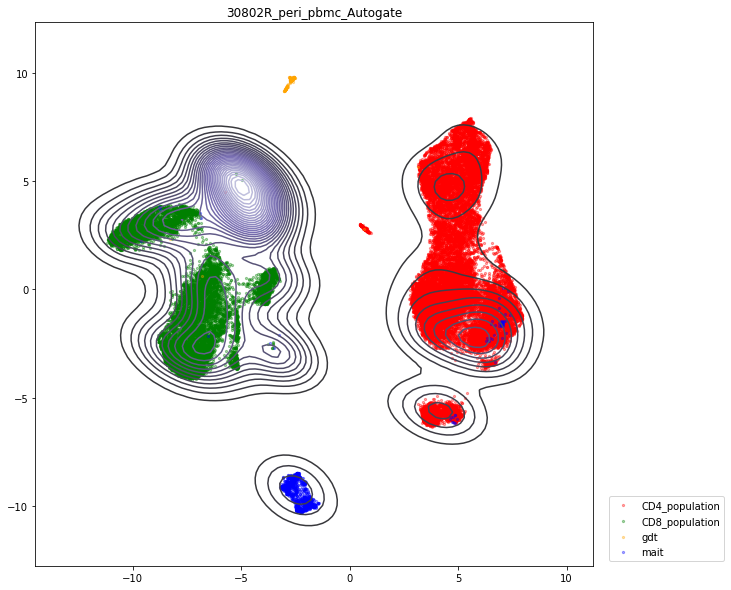

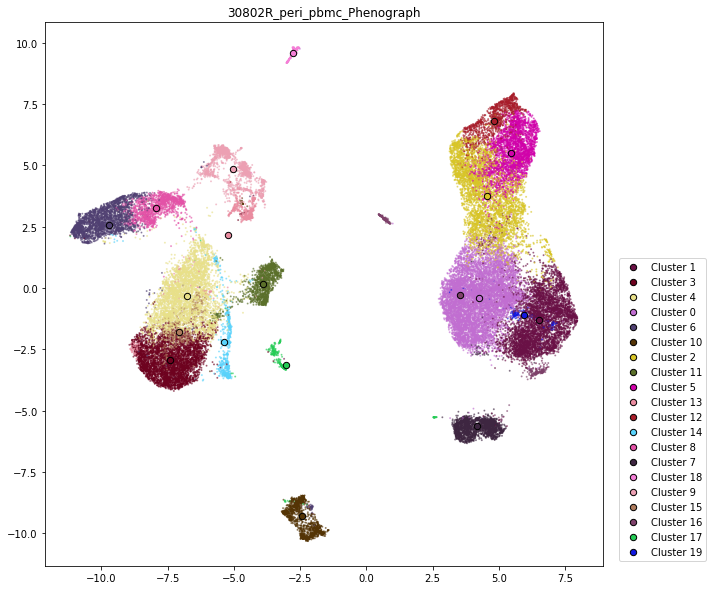

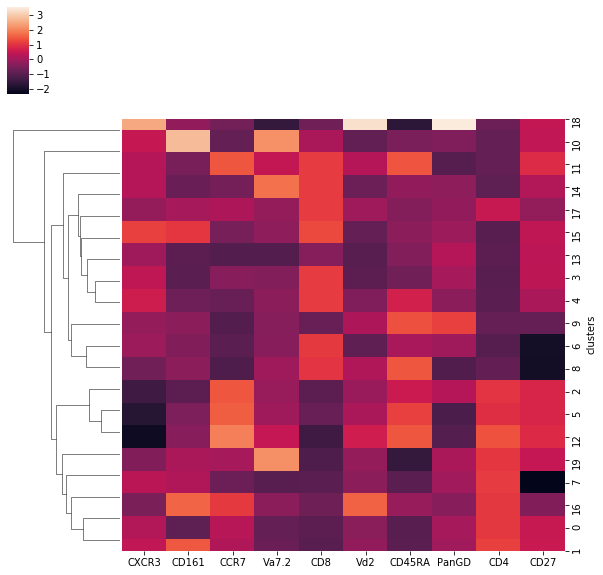

In [74]:
high_dim_plots(t, '30802R_peri_pbmc', n=200000)